In [1]:
import arviz as az
import matplotlib.pyplot as plt
import pandas as pd
import pymc as pm
import numpy as np
from pymc_marketing.customer_choice.mixed_logit import MixedLogit
from pymc_marketing.paths import data_dir

/Users/nathanielforde/mambaforge/envs/pymc-marketing-dev/lib/python3.12/site-packages/pymc_marketing/pytensor_utils.py:34: FutureWarning: `pytensor.graph.basic.ancestors` was moved to `pytensor.graph.traversal.ancestors`. Calling it from the old location will fail in a future release.
  from pytensor.graph.basic import ancestors


In [2]:
az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100

In [3]:
data_path = data_dir / "TravelMode_wide.csv"
df = pd.read_csv(data_path)
df.head()

,individual,wait_air,wait_bus,wait_car,wait_train,vcost_air,vcost_bus,vcost_car,vcost_train,travel_air,travel_bus,travel_car,travel_train,gcost_air,gcost_bus,gcost_car,gcost_train,mode,income,size
0,1,69,35,0,34,59,25,10,31,100,417,180,372,70,70,30,71,car,35,1
1,2,64,53,0,44,58,25,11,31,68,399,255,354,68,85,50,84,car,30,2
2,3,69,35,0,34,115,53,23,98,125,882,720,892,129,149,101,195,car,40,1
3,4,64,53,0,44,49,21,5,26,68,399,180,354,59,81,32,79,car,70,3
4,5,64,53,0,44,60,26,8,32,144,449,600,404,82,94,99,93,car,45,2


In [4]:
utility_eqs = [
    "car ~ wait_car + vcost_car + travel_car |  |  wait_car",
    "bus ~ wait_bus + vcost_bus + travel_bus |  |  wait_bus",
    "train ~ wait_train + vcost_train + travel_train |  | wait_train",
    "air ~ wait_air + vcost_air + travel_air |  |  wait_air",
]
mxl = MixedLogit(
    df,
    utility_eqs,
    depvar="mode",
    covariates=["wait", "vcost", "travel"],
)

mxl

In [5]:
mxl.sample(
    fit_kwargs={
        "target_accept": 0.95,
        "tune": 2000,
        "draws": 5000,
        "chains": 4,
        "cores": 4,
        "nuts_sampler": "numpyro",
    }
)

Sampling: [alphas_, betas_non_random, likelihood, mu_random, sigma_random, z_random]


  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/7000 [00:00<?, ?it/s]

Sampling: [likelihood]


Output()

In [6]:
az.summary(
    mxl.idata, var_names=["alphas_", "betas_non_random", "mu_random", "sigma_random"]
)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alphas_[car],-8.746,1.903,-12.454,-5.406,0.026,0.016,5604.0,8084.0,1.0
alphas_[bus],-0.462,1.046,-2.470,1.474,0.010,0.007,11194.0,13020.0,1.0
alphas_[train],0.334,0.913,-1.387,2.032,0.009,0.006,11098.0,13941.0,1.0
alphas_[air],0.014,5.046,-9.536,9.386,0.026,0.041,37960.0,13806.0,1.0
betas_non_random[vcost],-0.019,0.011,-0.039,0.000,0.000,0.000,13665.0,13398.0,1.0
betas_non_random[travel],-0.007,0.002,-0.011,-0.004,0.000,0.000,10967.0,12168.0,1.0
mu_random[wait],-0.198,0.036,-0.266,-0.133,0.001,0.000,5027.0,7090.0,1.0
sigma_random[wait],0.123,0.034,0.064,0.187,0.001,0.000,3691.0,7147.0,1.0


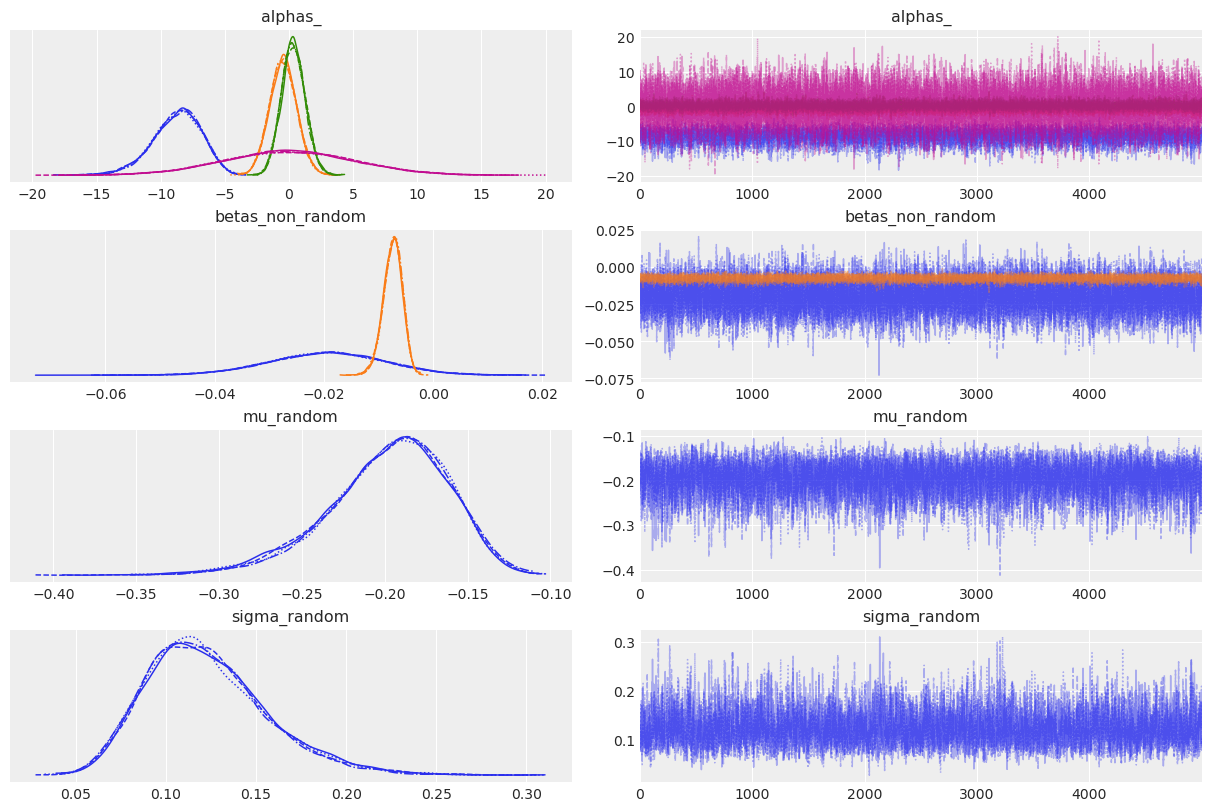

In [7]:
az.plot_trace(
    mxl.idata, var_names=["alphas_", "betas_non_random", "mu_random", "sigma_random"]
);

In [8]:
X_instruments = np.column_stack(
    [df[["gcost_car", "gcost_bus", "gcost_train", "gcost_air"]].values]
)

y_price = df[["vcost_car", "vcost_bus", "vcost_train", "vcost_air"]].values
instrumental_vars = {
    "X_instruments": X_instruments,
    "y_price": y_price,
    "diagonal": True,
}

mxl_1 = MixedLogit(
    df,
    utility_eqs,
    depvar="mode",
    covariates=["wait", "vcost", "travel"],
    instrumental_vars=instrumental_vars,
)

X, F, y = mxl_1.preprocess_model_data(df, utility_eqs)

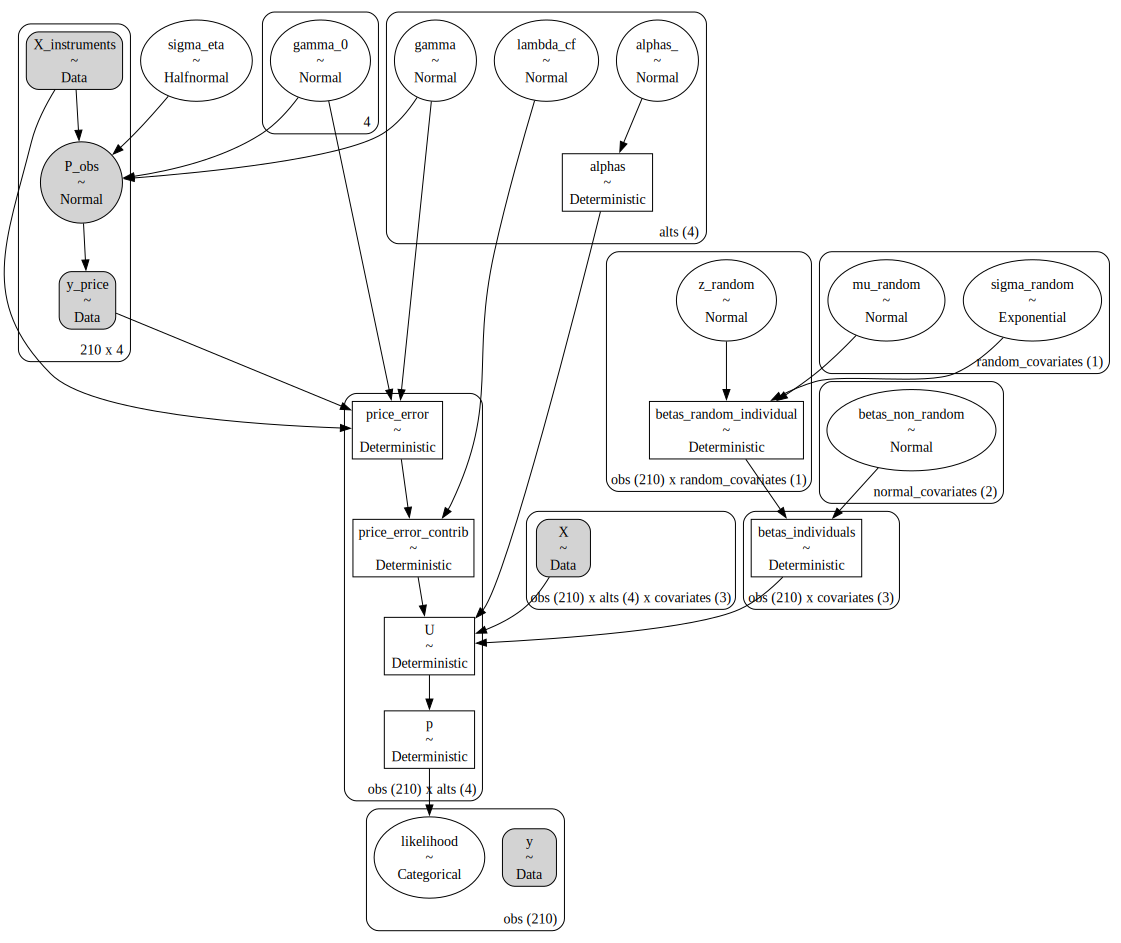

In [9]:
model_unobserved = mxl_1.make_model(mxl.X, mxl.F, mxl.y, observed=False)

pm.model_to_graphviz(model_unobserved)

In [10]:
p_obs_samples = np.random.normal(size=(df.shape[0], 4))
alphas_ = mxl.idata["posterior"]["alphas_"].mean(dim=["chain", "draw"])
z_random_ = mxl.idata["posterior"]["z_random"].mean(dim=["chain", "draw"])

# Generating data from model by fixing parameters
fixed_parameters = {
    "alphas_": alphas_.values,
    "gamma": [0.5, 0.5, 0.5, 0.5],
    "lambda_cf": [0.3, 0.3, 0.3, 0.3],
    "mu_random": np.array([-0.5]),
    "sigma_random": np.array([0.1]),
    "sigma_eta": 1.0,
    "betas_non_random": np.array([-0.8, 0.4]),
    "z_random": z_random_.values,
    "P_obs": p_obs_samples,
}
with pm.do(model_unobserved, fixed_parameters) as synthetic_model:
    idata = pm.sample_prior_predictive(
        random_seed=1000,
    )  # Sample from prior predictive distribution.
    synthetic_y = idata["prior"]["likelihood"].sel(draw=0, chain=0)

Sampling: [gamma_0, likelihood]


In [11]:
# Infer parameters conditioned on observed data
with pm.observe(model_unobserved, {"likelihood": synthetic_y}) as inference_model:
    idata_fixed = pm.sample_prior_predictive()
    idata_fixed.extend(
        pm.sample(
            random_seed=100, nuts_sampler="numpyro", chains=4, draws=1000, tune=2000
        )
    )

Sampling: [P_obs, alphas_, betas_non_random, gamma, gamma_0, lambda_cf, likelihood, mu_random, sigma_eta, sigma_random, z_random]


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

In [ ]:
az.summary(
    idata_fixed,
    var_names=[
        "alphas_",
        "betas_non_random",
        "mu_random",
        "sigma_random",
        "gamma",
        "lambda_cf",
        "gamma_0",
    ],
)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alphas_[car],-5.870,3.802,-13.461,0.894,0.056,0.067,4521.0,2772.0,1.0
alphas_[bus],4.148,3.514,-3.119,10.101,0.053,0.053,4307.0,3214.0,1.0
alphas_[train],1.799,3.327,-4.022,8.438,0.050,0.061,4428.0,2882.0,1.0
alphas_[air],0.044,4.998,-9.315,9.286,0.050,0.102,10112.0,2591.0,1.0
betas_non_random[vcost],-1.494,0.507,-2.467,-0.620,0.014,0.009,1230.0,990.0,1.0
betas_non_random[travel],0.658,0.207,0.290,1.055,0.006,0.004,1152.0,810.0,1.0
mu_random[wait],-0.651,0.193,-1.017,-0.293,0.005,0.003,1563.0,1245.0,1.0
sigma_random[wait],0.184,0.077,0.054,0.334,0.002,0.002,959.0,734.0,1.0
gamma[car],0.202,0.013,0.179,0.227,0.000,0.000,4670.0,3085.0,1.0
gamma[bus],0.241,0.014,0.214,0.266,0.000,0.000,4681.0,2969.0,1.0


In [13]:
fixed_parameters["alphas_"]

array([-8.74598322, -0.46160365,  0.3336127 ,  0.01382871])

array([<Axes: title={'center': 'betas_non_random\nvcost'}>,
       <Axes: title={'center': 'betas_non_random\ntravel'}>], dtype=object)

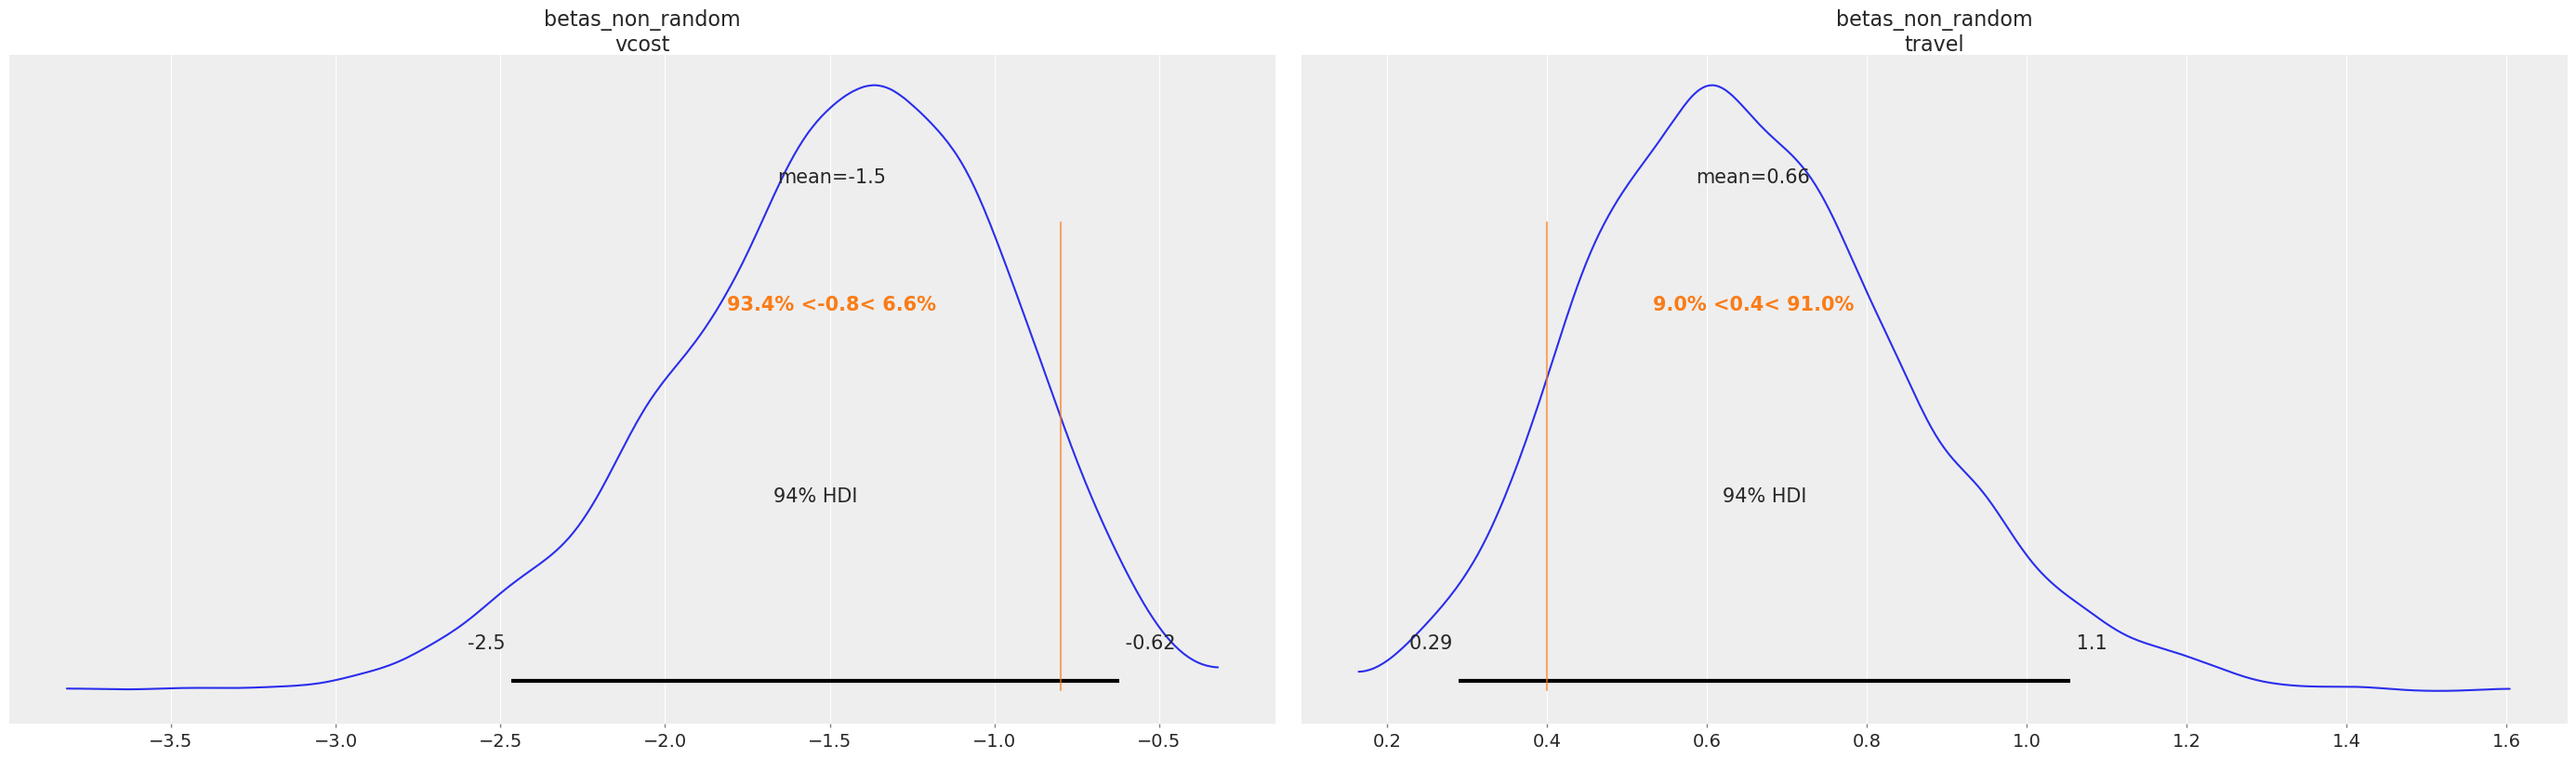

In [14]:
az.plot_posterior(
    idata_fixed,
    var_names=["betas_non_random"],
    ref_val=list(fixed_parameters["betas_non_random"]),
)

<Axes: title={'center': 'mu_random\nwait'}>

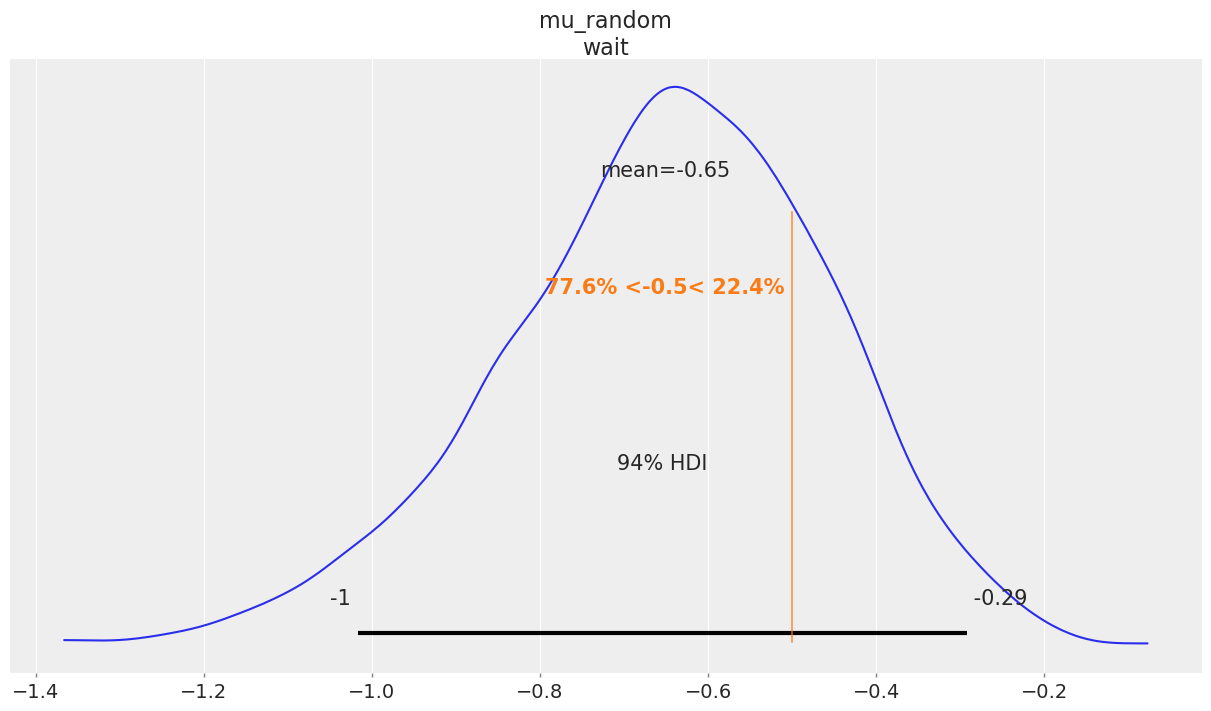

In [15]:
az.plot_posterior(
    idata_fixed, var_names=["mu_random"], ref_val=list(fixed_parameters["mu_random"])
)

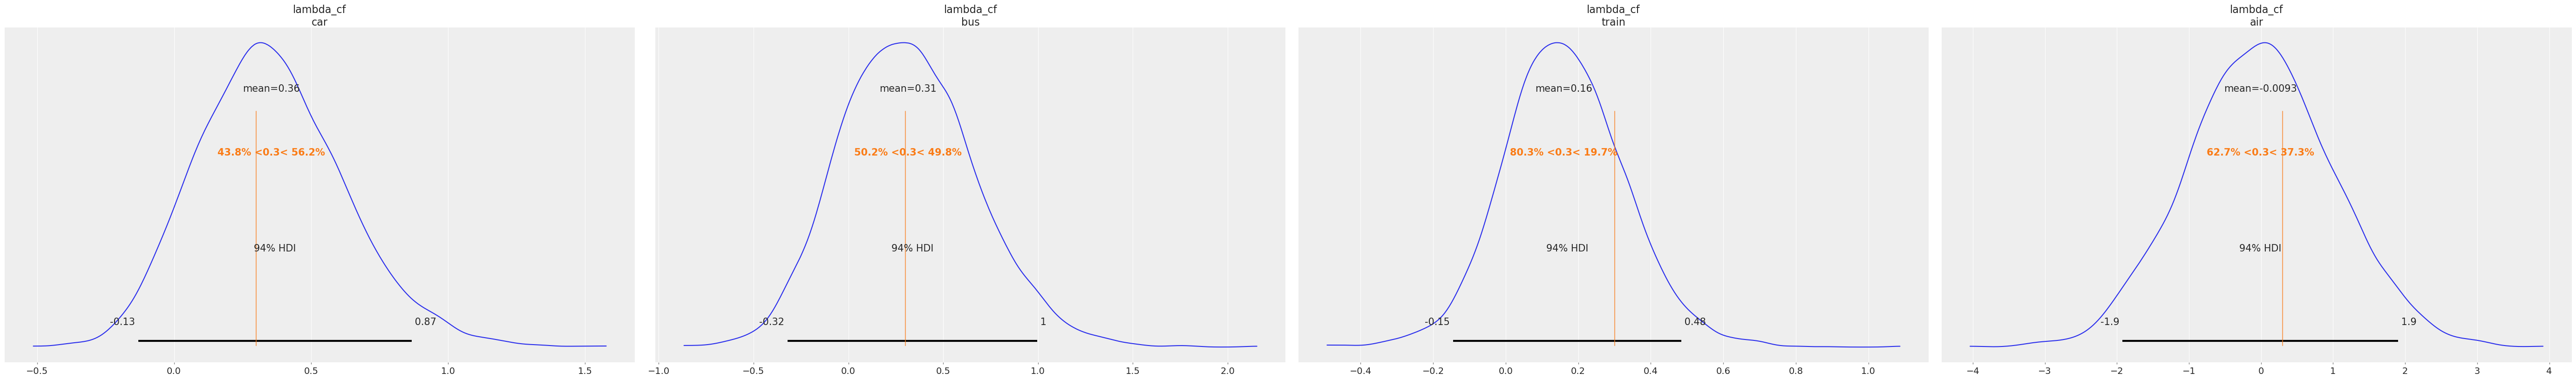

In [16]:
az.plot_posterior(
    idata_fixed, var_names=["lambda_cf"], ref_val=list(fixed_parameters["lambda_cf"])
);